# 0.0 IMPORTS

In [125]:
# data manipulation
import pandas                      as pd
import numpy                       as np
import pandas.io.sql               as psql
import psycopg2                    as pg

# data visualization
import seaborn                     as sns
import matplotlib.pyplot           as plt
import scikitplot                  as skplt
import mpl_toolkits.mplot3d.axes3d as axes3d
from matplotlib                    import gridspec
from scipy                         import stats
from tabulate                      import tabulate
import requests

# data preparation
from sklearn               import preprocessing as pp

# feature selection
from boruta                import BorutaPy

# metrics
from sklearn               import model_selection as ms

# machine learning models
from sklearn.ensemble      import RandomForestRegressor
from sklearn               import ensemble as en
from sklearn               import neighbors as nh
from sklearn               import linear_model as lm
from sklearn.ensemble      import RandomForestClassifier, GradientBoostingClassifier
from lightgbm              import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import random                as rd
import pickle
from sklearn.model_selection import train_test_split

# stetical
import warnings
from IPython.display       import Image
from IPython.core.display  import HTML


## 0.1 Helper Functions

### Settings

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
  
    sns.set()
    
jupyter_settings()
    
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'

Populating the interactive namespace from numpy and matplotlib


### Metrics

In [4]:
def precision_at_k( data, k=2000 ):
    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking Order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
   
    return data.loc[k, 'precision_at_k']

def recall_at_k( data, k=2000 ):
    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking Order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
   
    return data.loc[k, 'recall_at_k']

### Plots

In [5]:
def graphic_percentage(ax,total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}'.format(height/total*100),
                ha="center") 
    show

In [6]:
def cramer_v( x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0 , chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
   
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1 ) ) )  

### Models

In [7]:
def model_results (model_ml, model_name, df, k ):
    
    precision_list = []
    recall_list = []
    
    #prediction
    yhat_proba_model = model_ml.predict_proba(x_val)

    # propensity score
    df['score'] = yhat_proba_model[:, 1].tolist()

    # sort clients by propensity score
    df = df.sort_values( 'score', ascending=False )

    # compute precision at k 
    precision_model = precision_at_k( df, k )
    
    # compute recall at k
    recall_model = recall_at_k( df, k )
    
    precision_list.append(precision_model)
    recall_list.append(recall_model)
   
    # dataframe
    model_rank = pd.DataFrame(columns = {'Model':[], "Precision_at_k": [], "Recall_at_k": []})
    
    new_row = {'Model': model_name, 
               'Precision_at_k': precision_model,
               'Recall_at_k': recall_model}
            
    model_rank = model_rank.append(new_row, ignore_index = True)
    return model_rank

def cross_validation(model, x_train, y_train, k, data, num_folds):
   
    kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=17)
    precision_list=[]
    recall_list=[]
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):
        print('Model Name: {}'.format(model))
        print(f'Fold Number {i}/{num_folds}')
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold, y_train_fold)
        yhat = model.predict_proba(x_val_fold)

        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat[:, 1].tolist()
        data = data.sort_values('score', ascending=False)

        precision = precision_at_k(data , k)
        precision_list.append(precision)
        
        recall = recall_at_k(data , k)
        recall_list.append(recall)
        
        i+=1
        
    df = pd.DataFrame({'Model Name': type(model).__name__, 
                       'Precision@K Mean': np.mean(precision_list).round(4), 
                       'Precision@K STD': np.std(precision_list).round(4),
                       'Recall@K Mean': np.mean(recall_list).round(4), 
                       'Recall@K STD': np.std(recall_list).round(4)}, index = [0])
    
    return df

## 0.2 Loading Data

### 0.2.1 Loading from DB

In [ ]:
## Credentials
# host ='comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com' 
# port = 5432
# database ='comunidadedsdb'
# user ='member'
# pwd ='cdspa'

## Conn creation
# conn = pg.connect( host=host, 
#                    port=port,
#                    database=database,
#                    user=user, 
#                    password=pwd)

## Script to view db schema/tables

#SELECT nspname
#FROM pg_catalog.pg_namespace pn 

#select tablename
#from pg_catalog.pg_tables
#where schemaname = 'pa004

# query_tables = """
#     SELECT *
#     FROM pa004.users u LEFT JOIN pa004.vehicle   v  ON ( u.id = v.id )
#                        LEFT JOIN pa004.insurance i  ON ( u.id = i.id  )
#     """

# df_raw = pd.read_sql( query_tables, conn )
# conn.close()

### 0.2.2 Loading from CSV

In [183]:
df_raw = pd.read_csv( '../data/train.csv', sep=';' )
df_raw = df_raw.drop(columns=['id.1', 'id.2'])
df_raw.sample(5)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
367625,273404,Female,37,14.0,124.0,1,1-2 Year,Yes,0,23266.0,127,1
23222,185505,Male,22,50.0,152.0,1,< 1 Year,Yes,0,2630.0,294,0
201289,82869,Female,68,28.0,26.0,1,1-2 Year,Yes,0,32060.0,186,0
363915,244519,Female,28,24.0,152.0,1,< 1 Year,No,1,2630.0,98,0
337380,29960,Female,24,15.0,152.0,1,< 1 Year,Yes,0,36998.0,267,0


# 1.0 DATA DESCRIPTION

In [184]:
df1 = df_raw.copy()

## 1.1 Data Dimension

In [185]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## 1.2 Data Dtypes

In [186]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check Uniques

In [187]:
print('Column - previously_insured: {}'.format(df1['previously_insured'].unique()))
print('\nColumn - annual_premium: {}'.format(df1['annual_premium'].unique()))
print('\nColumn - response: {}'.format(df1['response'].unique()))
print('\nColumn - gender: {}'.format(df1['gender'].unique()))
print('\nColumn - policy_sales_channel: {}'.format(df1['policy_sales_channel'].unique()))
print('\nColumn - driving_license: {}'.format(df1['driving_license'].unique()))
print('\nColumn - vehicle_age: {}'.format(df1['vehicle_age'].unique()))
print('\nColumn - vehicle_damage: {}'.format(df1['vehicle_damage'].unique()))

Column - previously_insured: [0 1]

Column - annual_premium: [23367. 31409. 46622. ... 67909. 91305. 20706.]

Column - response: [0 1]

Column - gender: ['Male' 'Female']

Column - policy_sales_channel: [152.  14. 160. 124.  13.  26. 151. 157. 156. 122.  23.  11. 163.  12.
 154.  31.  19. 120.  55.  56.  24.   8.  10.   9.  61.  29.  52.  22.
 150. 147.  15. 155.  60.   7. 125.  30.  18.  25. 145. 158. 139. 135.
 136. 131.   3.   1. 127. 105.  16. 140.  91. 128. 113.  94. 132.  54.
  42. 103. 153.   4.  51. 116.  36. 107. 146. 108.  47. 138. 111.  35.
 114.  45.  86. 121. 123. 109.  59. 119.  37.  65. 133.  88.  38.  48.
 110. 129.  44.  39. 106.  89. 159.  80.  92.  63.  21. 148. 104. 118.
 137.  93.  32.  64.  20.  71. 117.  53. 112.  70.  98.  78.  76.  81.
 130.  74.  90.  83.  40.  99.  46.  79.   2.  66.  49.  97.  73.  28.
  17. 101.  58. 126.  27.  69.  34. 102. 149.  87.   6.  95.  41. 100.
  75. 134.  62.  96. 115.  82.  57.  33.  67.  68.  50.  43. 144.  84.
 143.]

Column -

## 1.3 Check NA

In [14]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4 Check Data Balance

In [15]:
df1['response'].value_counts(normalize = True)

0    0.877437
1    0.122563
Name: response, dtype: float64

## 1.4 Change Types

In [188]:
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)
df1['region_code'] = df1['region_code'].astype(int)

## 1.5 Descriptive Statistical

In [17]:
num_attributes = df1[['age','annual_premium','vintage']]
cat_attributes = df1[['gender','driving_license','vehicle_age','vehicle_damage','previously_insured']]

### 1.5.1 Numerical Attributes

In [18]:
# Central Tendency - Mean and Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply( np.median)).T

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std)).T
d2 = pd.DataFrame( num_attributes.apply( min)).T
d3 = pd.DataFrame( num_attributes.apply( max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis())).T

# concatenate
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


### 1.6.2 Categorical Attributes

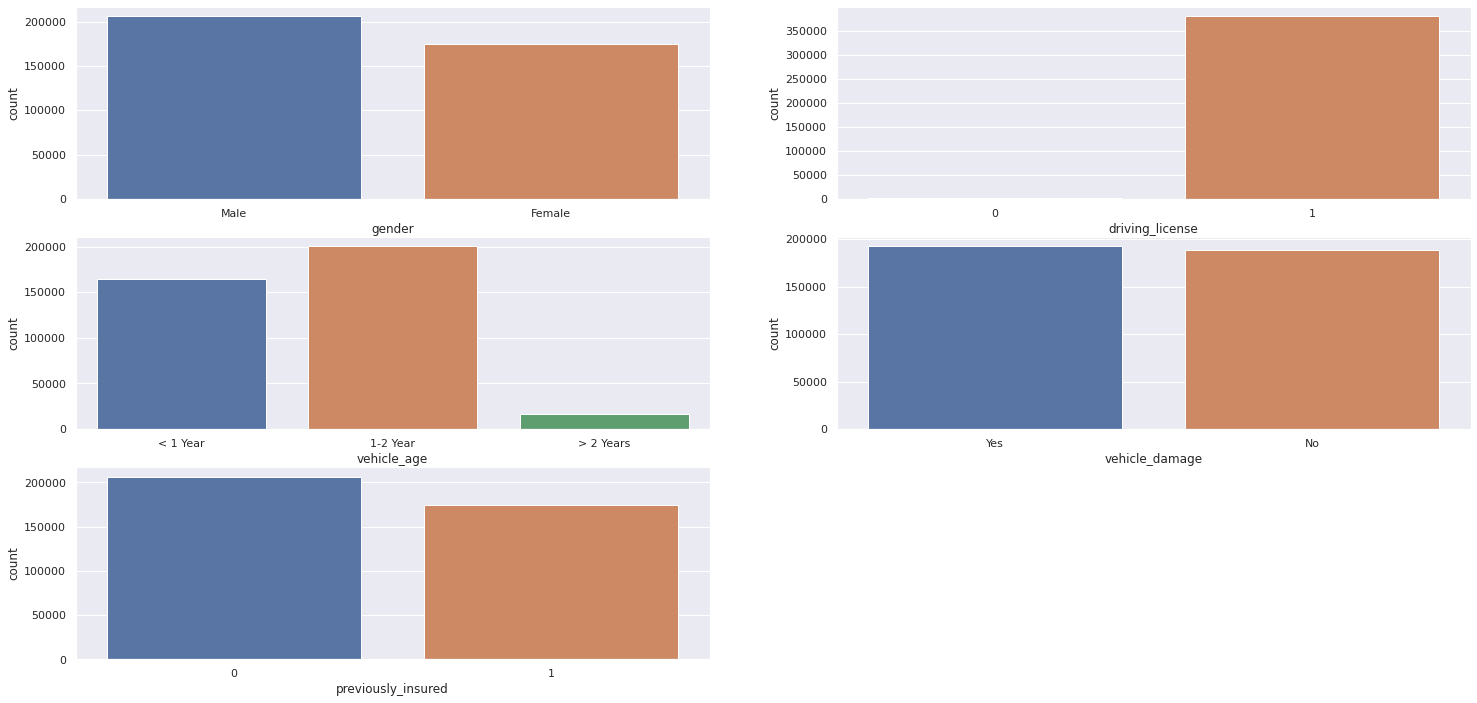

In [19]:
plt.subplot(3, 2, 1)
sns.countplot(df1['gender']);

plt.subplot(3, 2, 2)
sns.countplot(df1['driving_license']);

plt.subplot(3, 2, 3)
sns.countplot(df1['vehicle_age']);

plt.subplot(3, 2, 4)
sns.countplot(df1['vehicle_damage']);

plt.subplot(3, 2, 5)
sns.countplot(df1['previously_insured']);

# 2.0 FEATURE ENGINEERING

In [189]:
df2 = df1.copy()

## 2.1 Mind Map Hypothesis

In [ ]:
Image( '/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/Images/insurance_mindmap.png')

## 2.2 Hypothesis Creation

### 2.2.1 Custumer Hypothesis 

**1**. Insurance for women is more expensive on average than for men

**2**. Older customers are more interested in "cross-selling"

**3**. From the age of 60 onwards, annual health insurance becomes more expensive

**4**. The region is directly related to the interest or not in car insurance

### 2.2.2 Vehicle Hypothesis 

**1**. Customers with already damaged vehicles are more interested in having insurance

**2**. Most customers with newer cars already have insurance

### 2.2.3 Insurance Hypothesis 

**1**. Customers who already have car insurance, are not interested in exchanging

**2**. Customers who pay more for insurance annually have less interest in purchasing another

## 2.3 Feature Engineering

In [190]:
# Change feature vehicle age 
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

# Change feature vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)

# 3.0 DATA FILTERING

In [191]:
df3 = df2.copy()

# 4.0 EXPLORATORY DATA ANALYSIS

In [192]:
df4 = df3.copy()

## 3.1 Univariate Analysis

### 3.1.1 Response Variable

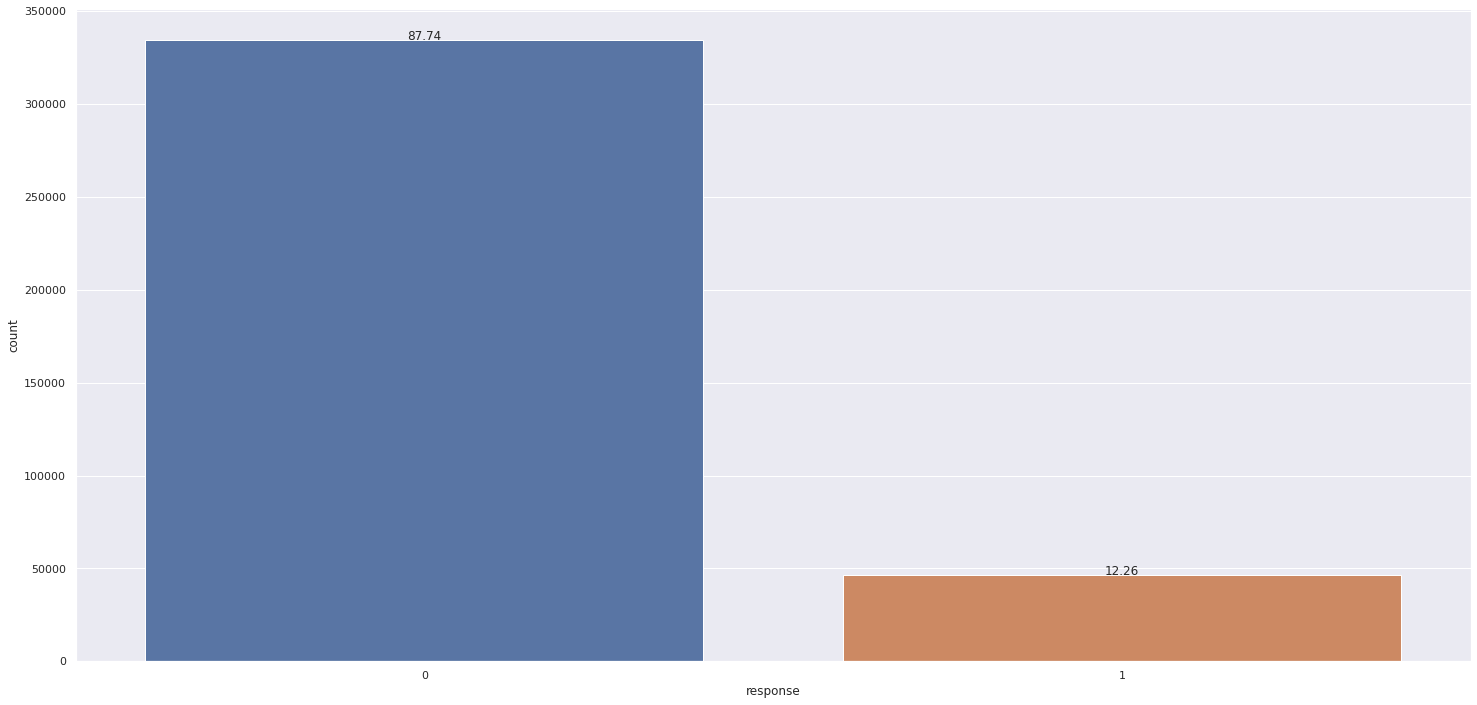

In [24]:
ax = sns.countplot(df3['response'])
total = len(df3['response'])
graphic_percentage(ax,total)

### 3.1.2 Numerical Variable

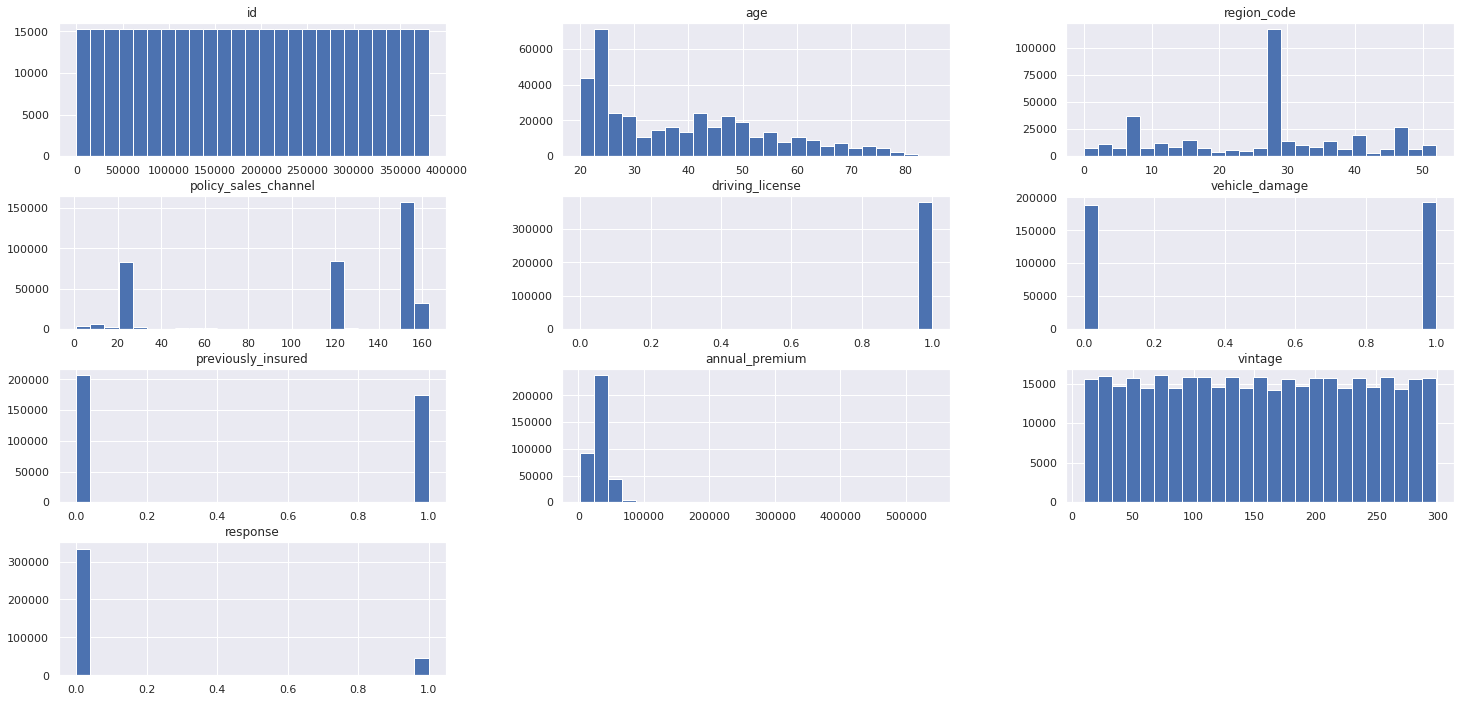

In [25]:
num_attributes = df3.select_dtypes( include=['int64' , 'float64'])
num_attributes.hist(bins=25);

### 3.1.3 Categorical Variable

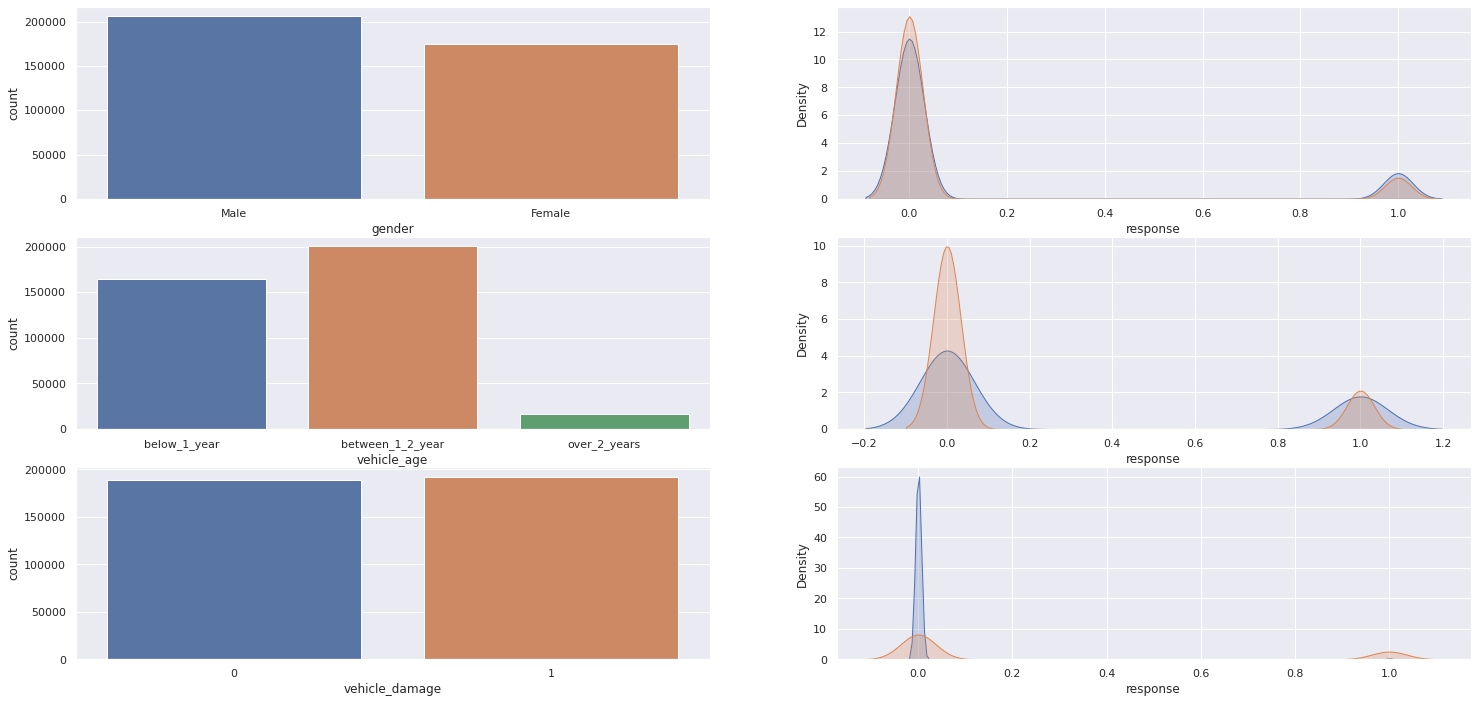

In [26]:
# gender
plt.subplot(3,2,1)
sns.countplot(df3['gender']);

plt.subplot(3,2,2)
sns.kdeplot( df3[df3['gender'] == 'Male']['response'], label='Male',shade=True);
sns.kdeplot( df3[df3['gender'] == 'Female']['response'], label='Female',shade=True);

# vehicle_age
plt.subplot(3,2,3)
sns.countplot(df3['vehicle_age']);

plt.subplot(3,2,4)
sns.kdeplot( df3[df3['vehicle_age'] == 'over_2_years']['response'], label='over_2_years',shade=True);
sns.kdeplot( df3[df3['vehicle_age'] == 'between_1_2_year']['response'], label='between_1_2_year',shade=True);
sns.kdeplot( df3[df3['vehicle_age'] == 'more_2_year']['response'], label='more_2_year',shade=True);

# vehicle_damage
plt.subplot(3,2,5)
sns.countplot(df3['vehicle_damage']);

plt.subplot(3,2,6)
sns.kdeplot( df3[df3['vehicle_damage'] == 0]['response'], label='No',shade=True);
sns.kdeplot( df3[df3['vehicle_damage'] == 1]['response'], label='Yes',shade=True);


## 3.2 Bivariate Analysis

### 3.2.1 Response Variable x Features

#### Age

In [ ]:
plt.subplot(1,3,1)
sns.boxplot( x='response' , y='age', data=df4);

aux1 =  df4.loc[df3['response'] == 0, 'age']
aux11 = df4.loc[df3['response'] == 1, 'age']

plt.subplot(1,3,2)
plt.title("Negative Response")
sns.histplot( aux1 );

plt.subplot(1,3,3)
plt.title("Positive Response")
sns.histplot( aux11 );

#### Annual Premium

In [ ]:
# With Outliers - Barplots
plt.subplot(2,2,1)
plt.title("All Data")
sns.boxplot( x='response' , y='annual_premium', data=df4);

# Without Outliers - Barplots
aux2 = df4[df4['annual_premium'] < 80000]
plt.subplot(2,2,2)
plt.title("Without Outliers")
sns.boxplot( x='response' , y='annual_premium', data=aux2);

# Histograms
aux21 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000 )]
aux22 = aux21.loc[aux21['response'] == 0, 'annual_premium']
aux23 = aux21.loc[aux21['response'] == 1, 'annual_premium']

plt.subplot(2,2,3)
plt.title("Negative Response")
sns.histplot( aux22 );

plt.subplot(2,2,4)
plt.title("Positive Response")
sns.histplot( aux23 );

#### Driving License

In [ ]:
aux3 = df4[['driving_license','response']].groupby('response').sum().reset_index()
aux3['driving_license_perc'] = aux3['driving_license'] / aux3['driving_license'].sum()
sns.barplot( x='response', y='driving_license',data=aux3 );

In [ ]:
aux3

#### Region Code

In [ ]:
aux4 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data=aux4 );

#### Previously Insured

In [ ]:
aux5 = df4[['id', 'previously_insured', 'response']].groupby( ['previously_insured', 'response'] ).count().reset_index()
sns.catplot( x='previously_insured', y='id', hue='response', kind='bar', data=aux5);

pd.crosstab(df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

#### Vehicle Age

In [ ]:
aux6 = df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index().sort_values(by='vehicle_age')
aux6.columns=[['vehicle_age','response','percentage']] 
aux6

#### Vehicle Damage

In [ ]:
aux7 = df4[['id', 'vehicle_damage', 'response']].groupby( ['vehicle_damage', 'response'] ).count().reset_index()
sns.catplot( x='vehicle_damage', y='id', hue='response', kind='bar', data=aux7);

pd.crosstab(df4['vehicle_damage'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

#### Vintage

In [ ]:
plt.subplot(1,3,1)
sns.boxplot( x='response', y='vintage', data=df4 );

aux8 = df4.loc[df3['response'] == 0, 'vintage']
aux81 = df4.loc[df3['response'] == 1, 'vintage']

plt.subplot(1,3,2)
plt.title("Negative Response")
sns.histplot(aux8);

plt.subplot(1,3,3)
plt.title("Positive Response")
sns.histplot(aux81);

#### Gender

In [ ]:
aux9 = df4[['id', 'gender', 'response']].groupby(['gender','response']).count().reset_index()
aux9.columns=[['gender','response','total']]

# Pie Chart
data = aux9['total'].squeeze().tolist()
labels = ['Female Response 0', 'Female Response 1', 'Male Response 0', 'Male Response 1']
plt.pie(data, labels = labels, autopct='%.0f%%')
plt.show()

#### Policy Sales Channel

In [ ]:
aux10 = df4[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux10 );
plt.xticks(rotation=60);

In [ ]:
aux101 = pd.crosstab(df4['policy_sales_channel'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

aux101.plot(kind='bar', 
            stacked=True)

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Policy Sales Channel")
plt.ylabel("Proportion")
plt.show()

### 3.2.2 Hypothesis Validation

#### H1. Insurance for women is more expensive on average than for men - FALSE

In [ ]:
h1 = df3[['gender','annual_premium']].groupby('gender').mean().reset_index()
sns.barplot( x='gender', y='annual_premium', data=h1);

#### H2. Older customers are more interested in "cross-selling" - VOLTAR

In [ ]:
h2 = df3[['vintage','response']].groupby('vintage').sum().reset_index()

plt.subplot(1,2,1)
sns.scatterplot(x='vintage',y='response',data=h2);

plt.subplot(1,2,2)
sns.heatmap(h2.corr(method='pearson'), annot=True);

#### H3. From the age of 60 onwards, annual health insurance becomes more expensive - TRUE

In [ ]:
h3 = df3[['age','annual_premium']].groupby('age').mean().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='age',y='annual_premium',data=h3)
plt.xticks(rotation=75)

plt.subplot(1,3,2)
sns.regplot(x='age',y='annual_premium',data=h3);

plt.subplot(1,3,3)
sns.heatmap(h3.corr(method='pearson'), annot=True);


#### H4. The region is directly related to the interest or not in car insurance - FALSE (except region 28)

In [ ]:
h4 = df3[['id','region_code', 'response']].groupby(['region_code','response']).count().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(data=h4, x="region_code", y="id", hue="response");

h42 = df3[['region_code', 'response']].groupby('region_code').sum().reset_index()

plt.subplot(1,3,2)
sns.heatmap(h42.corr(method='pearson'), annot=True);

h43 = df3[df3['response'] == 0]
h44 = h43[['region_code', 'response']].groupby('region_code').count().reset_index()

plt.subplot(1,3,3)
sns.heatmap(h44.corr(method='pearson'), annot=True);


#### H5. Customers with already damaged vehicles already have insurance - FALSE

In [ ]:
h5 = df3[['vehicle_damage','previously_insured']].groupby('vehicle_damage').sum().reset_index()
sns.barplot(x="vehicle_damage", y="previously_insured", data=h5);

#### H6. Most customers with newer cars already have insurance - TRUE

In [ ]:
h6 = df3[['vehicle_age','previously_insured']].groupby('vehicle_age').sum().reset_index()
sns.barplot(x="vehicle_age", y="previously_insured", data=h6);

#### H7. Customers who already have car insurance, are not interested in exchanging - TRUE

In [ ]:
h7 = df3[df3['previously_insured'] == 1]
h72 = h7[['previously_insured', 'response']].groupby('response').sum().reset_index()
sns.barplot(x="response", y="previously_insured", data=h72);

#### H8. Clientes que pagam mais de seguro anualmente tem menos interesse em adquirir outro - VOLTAR

## 3.3 Multivariate Analysis

### 3.3.1 Numerical Attributes

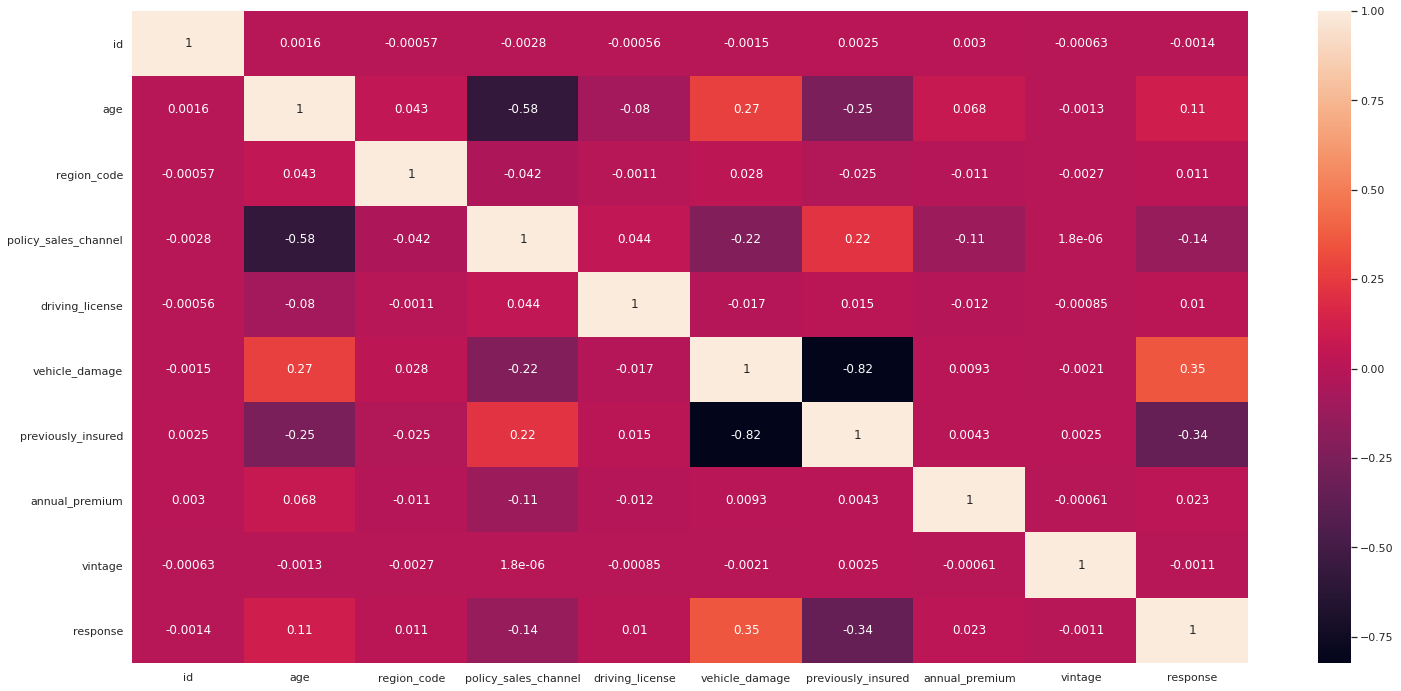

In [27]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot=True);

### 3.3.2 Categorical Attributes

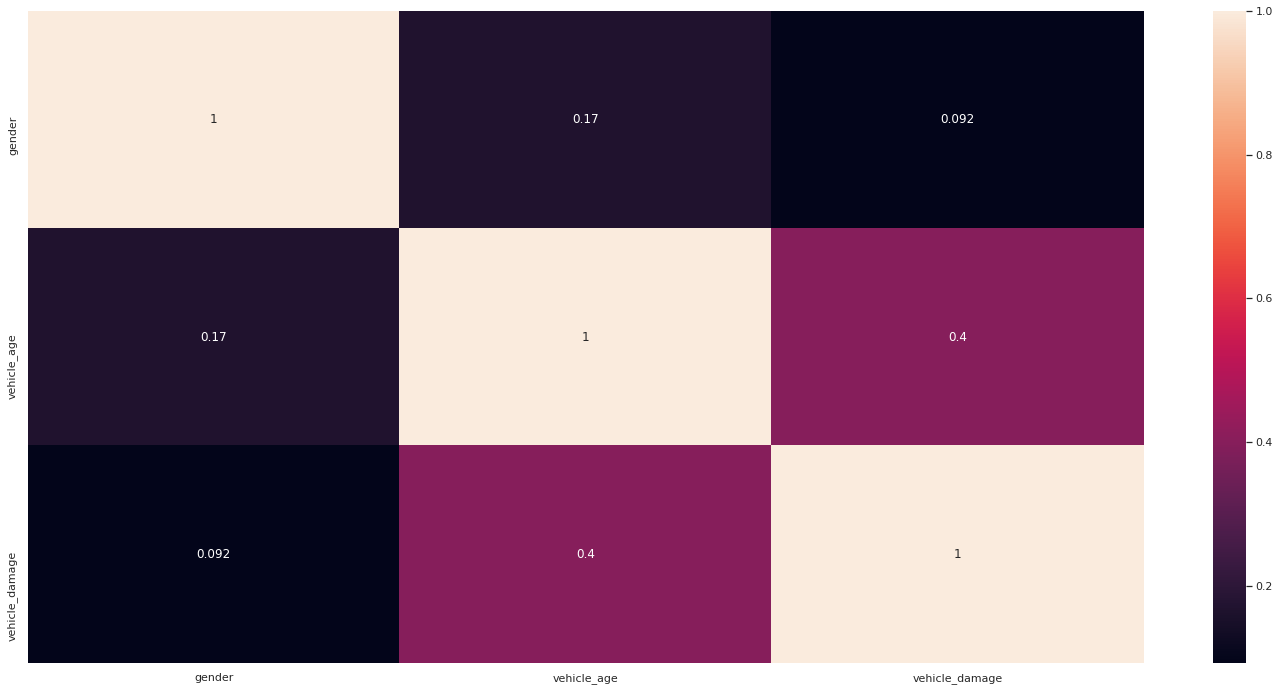

In [28]:
# only categorical data
a = df3[cat_attributes.columns]

# calculate cramer V
a1 = cramer_v(a['gender'], a['gender'])
a2 = cramer_v(a['gender'], a['vehicle_age'])
a3 = cramer_v(a['gender'], a['vehicle_damage'])

a4 = cramer_v(a['vehicle_age'], a['gender'])
a5 = cramer_v(a['vehicle_age'], a['vehicle_age'])
a6 = cramer_v(a['vehicle_age'], a['vehicle_damage'])

a7 = cramer_v(a['vehicle_damage'], a['gender'])
a8 = cramer_v(a['vehicle_damage'], a['vehicle_age'])
a9 = cramer_v(a['vehicle_damage'], a['vehicle_damage'])

# final dataset
d = pd.DataFrame({'gender': [a1,a2,a3],
              'vehicle_age': [a4,a5,a6],
              'vehicle_damage': [a7,a8,a9] } )

d = d.set_index( d.columns)

sns.heatmap(d, annot=True);

# 5.0 DATA PREPARATION

In [193]:
df5 = df4.copy()

In [194]:
x = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( x, y, test_size=0.20)

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1 Standardization

In [47]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values)
pickle.dump(ss, open('/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/annual_premium_scaler.pkl', 'wb'))

## 5.2 Rescaling

In [48]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform( df5[['age']].values )
pickle.dump(mms_age, open('/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/age_scaler.pkl', 'wb'))

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump(mms_vintage, open('/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/vintage_scaler.pkl', 'wb'))

## 5.3 Encoder

In [49]:
# gender >  Target Encoding
target_encode_gender = df5.groupby( 'gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump(target_encode_gender, open('/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/target_encode_gender_scaler.pkl', 'wb'))

# region_code >  Target Encoding
target_encode_region_code = df5.groupby( 'region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump(target_encode_region_code, open('/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/target_encode_region_code_scaler.pkl', 'wb'))

# vehicle_age > One Hot Encoding 
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )
pickle.dump(ss, open('/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/annual_premium_scaler.pkl', 'wb'))

# policy_sales_channel > Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len( df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump(fe_policy_sales_channel, open('/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/fe_policy_sales_channel_scaler.pkl', 'wb'))

## 5.4 Validation Preparation

In [50]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.fit_transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.fit_transform( x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.fit_transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0 FEATURE SELECTION

In [52]:
df6 = df5.copy()

## 6.1  Boruta Algorithm

In [ ]:
# Training and test dataset for Boruta

# x_train_n = df6.drop( ['id', 'response'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# define model
# et = en.ExtraTreesClassifier( n_jobs=-1 )

# define Boruta
# boruta = BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n , y_train_n)

In [ ]:
# cols_selected = boruta.support_.tolist()

# best features
# x_train_fs = df6.drop( ['id', 'response'], axis=1 )
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
# cols_not_selected = np.setdiff1d(x_train_fs.columns, cols_selected_boruta)

## 6.2 Features Importance

In [ ]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df6.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature Ranking')
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature': i , 'importance': j}, index=[0])
    df = pd.concat( [df, aux], axis=0 )

print( df.sort_values( 'importance', ascending=False) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar( range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks( range(x_train_n.shape[1]), indices)
plt.xlim( [-1, x_train_n.shape[1]])
plt.show()

# 7.0 MACHINE LEARNING 

In [53]:
df7 = df6.copy()

cols_selected = ['annual_premium','vintage', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

x_train = df7[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation.copy()

## 7.1 KNN

<Figure size 720x432 with 0 Axes>

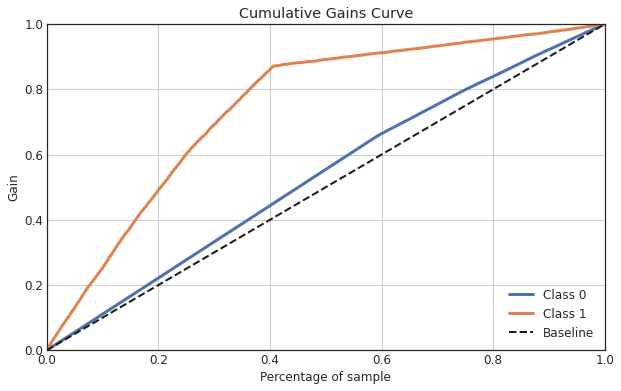

In [29]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction - Power of generalization
yhat_knn = knn_model.predict_proba( x_val )

# Accumulative Gain
with plt.style.context("seaborn-white"):
     plt.figure(figsize(10, 6))
     skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

<Figure size 720x432 with 0 Axes>

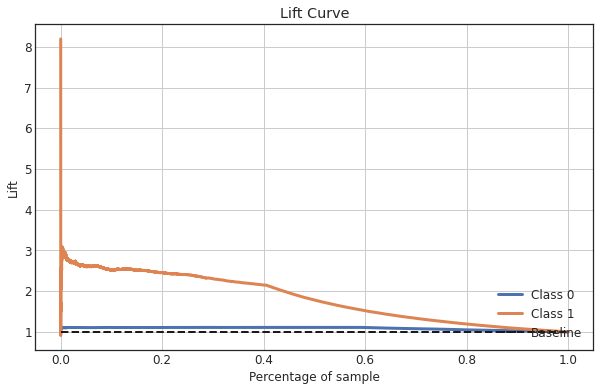

In [30]:
# Lift Curve
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6))
    skplt.metrics.plot_lift_curve(y_val,yhat_knn);

## 7.2 Logistic Regression

<Figure size 720x432 with 0 Axes>

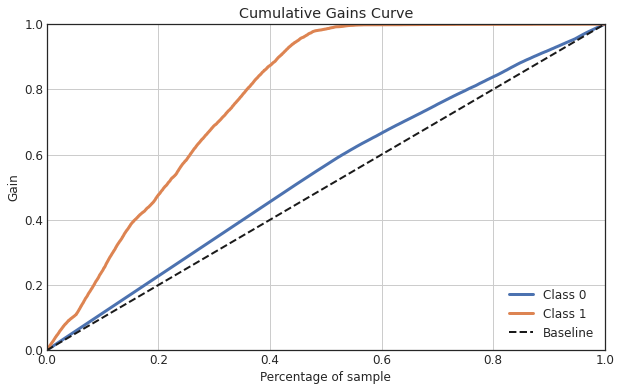

In [31]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 )

# model training
lr_model.fit( x_train, y_train )

# model prediction - Power of generalization
yhat_lr = lr_model.predict_proba( x_val )

# Accumulative Gain
with plt.style.context("seaborn-white"):
     plt.figure(figsize(10, 6))
     skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

<Figure size 720x432 with 0 Axes>

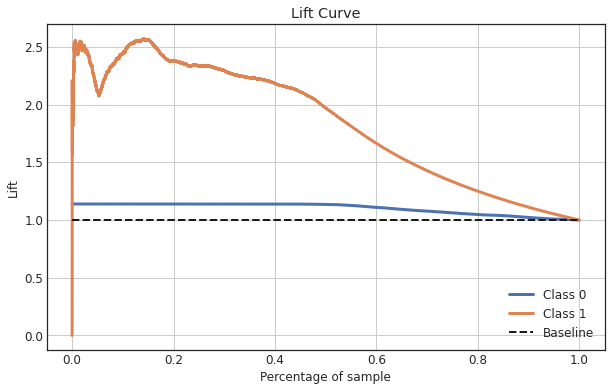

In [32]:
# Lift Curve
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6))
    skplt.metrics.plot_lift_curve(y_val,yhat_lr);

## 7.3 Random Forest Classifier

<Figure size 720x432 with 0 Axes>

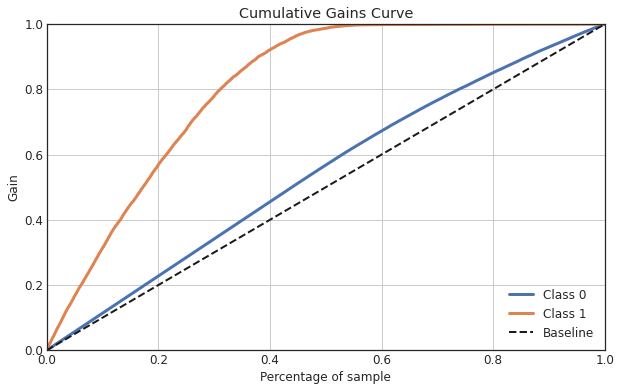

In [33]:
# model definition
rf = RandomForestClassifier(max_depth=10, random_state=42)

# model training
rf.fit( x_train, y_train )

# model prediction - Power of generalization
yhat_rf = rf.predict_proba( x_val )

# Accumulative Gain
with plt.style.context("seaborn-white"):
     plt.figure(figsize(10, 6))
     skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);

<Figure size 720x432 with 0 Axes>

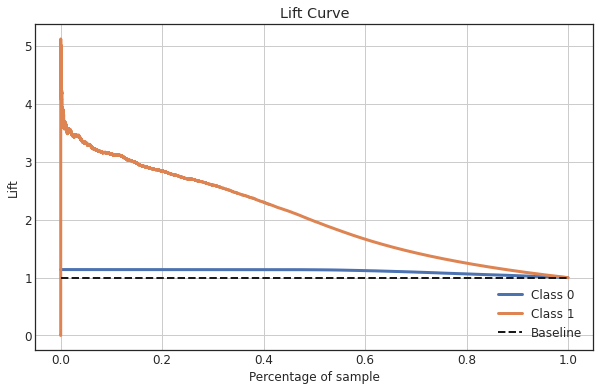

In [34]:
# Lift Curve
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6))
    skplt.metrics.plot_lift_curve(y_val,yhat_rf);

## 7.4 Gradient Boosting Classifier - XGBoost

<Figure size 720x432 with 0 Axes>

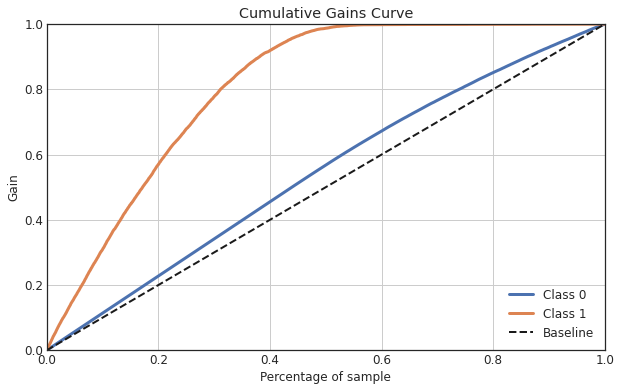

In [35]:
# model definition
model_xgb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
             max_depth=3, random_state=0)

# model training
model_xgb.fit( x_train, y_train )

# model prediction - Power of generalization
yhat_xgb = model_xgb.predict_proba( x_val )

# Accumulative Gain
with plt.style.context("seaborn-white"):
     plt.figure(figsize(10, 6))
     skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb);

<Figure size 720x432 with 0 Axes>

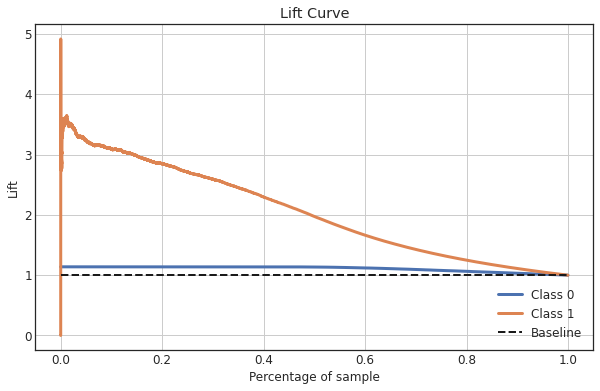

In [36]:
# Lift Curve
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6))
    skplt.metrics.plot_lift_curve(y_val,yhat_xgb);

## 7.5 LGBM Classifier

<Figure size 720x432 with 0 Axes>

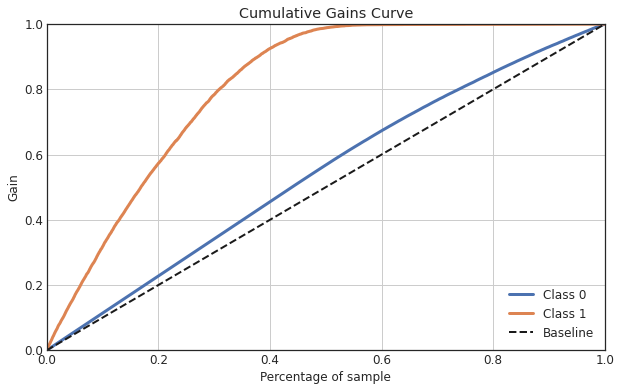

In [27]:
# model definition
lgbm = LGBMClassifier(n_jobs =-1, max_depth=10)

# model training
lgbm.fit( x_train, y_train )

# model prediction - Power of generalization
yhat_lgbm = lgbm.predict_proba( x_val )

# Accumulative Gain
with plt.style.context("seaborn-white"):
     plt.figure(figsize(10, 6))
     skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm);

<Figure size 720x432 with 0 Axes>

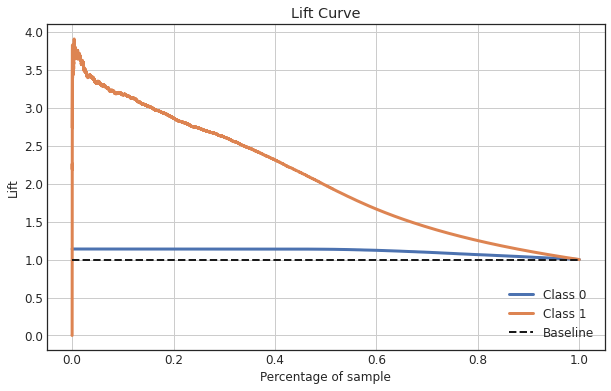

In [28]:
# Lift Curve
with plt.style.context("seaborn-white"):
    plt.figure(figsize(10, 6))
    skplt.metrics.plot_lift_curve(y_val,yhat_lgbm);

## 7.6 Resume - Cumulative Gains Curve

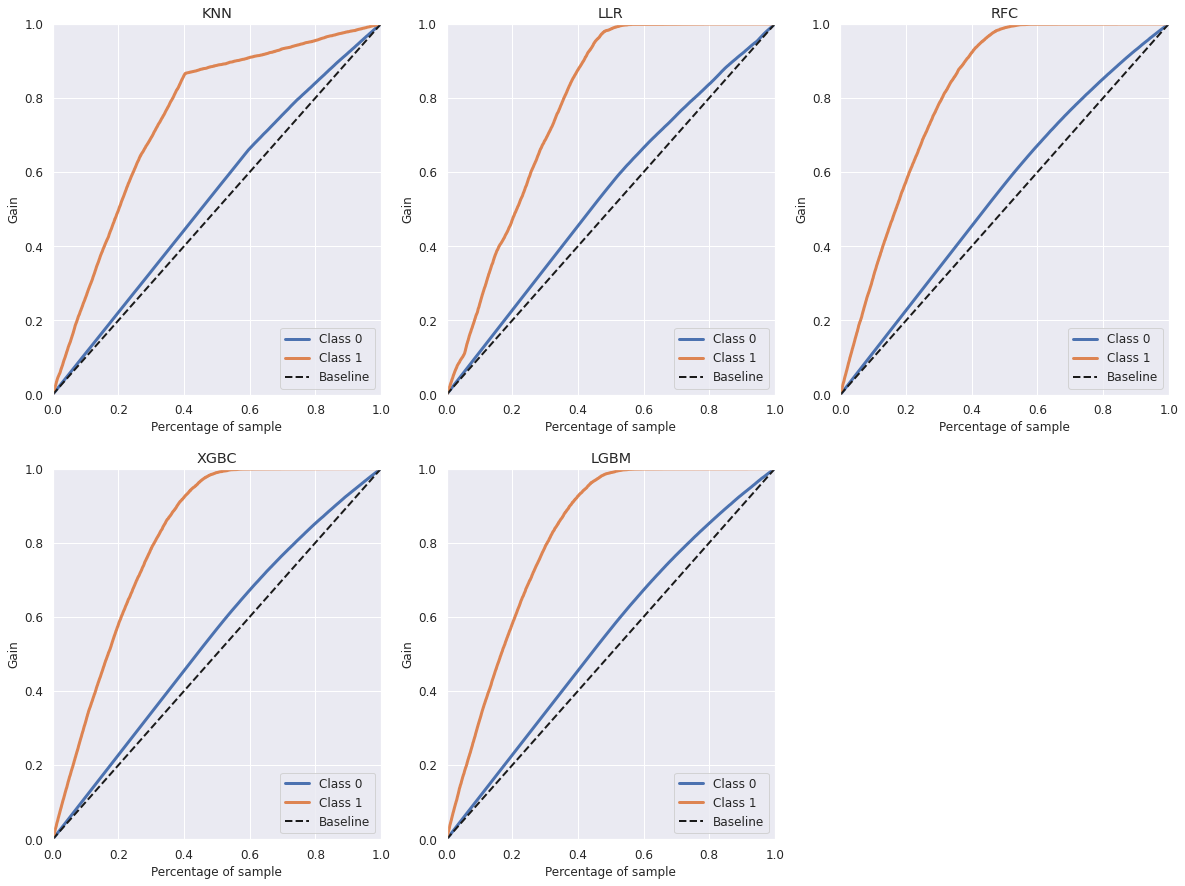

In [51]:
fig = plt.figure(figsize=(20,15))
specs = gridspec.GridSpec(ncols=3,nrows=2)

ax6 = fig.add_subplot(specs[0, 0]) 
ax7 = fig.add_subplot(specs[0, 1]) 
ax8 = fig.add_subplot(specs[0, 2]) 
ax9 = fig.add_subplot(specs[1, 0]) 
ax10 = fig.add_subplot(specs[1, 1]) 

skplt.metrics.plot_cumulative_gain( y_val, yhat_knn, ax=ax6 ,  title='KNN');
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr , ax=ax7 , title='LLR' );
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf , ax=ax8 , title='RFC' );
skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb , ax=ax9 , title='XGBC' );
skplt.metrics.plot_cumulative_gain( y_val, yhat_lgbm , ax=ax10 , title='LGBM' );

## 7.7 Resume - Lift Curve

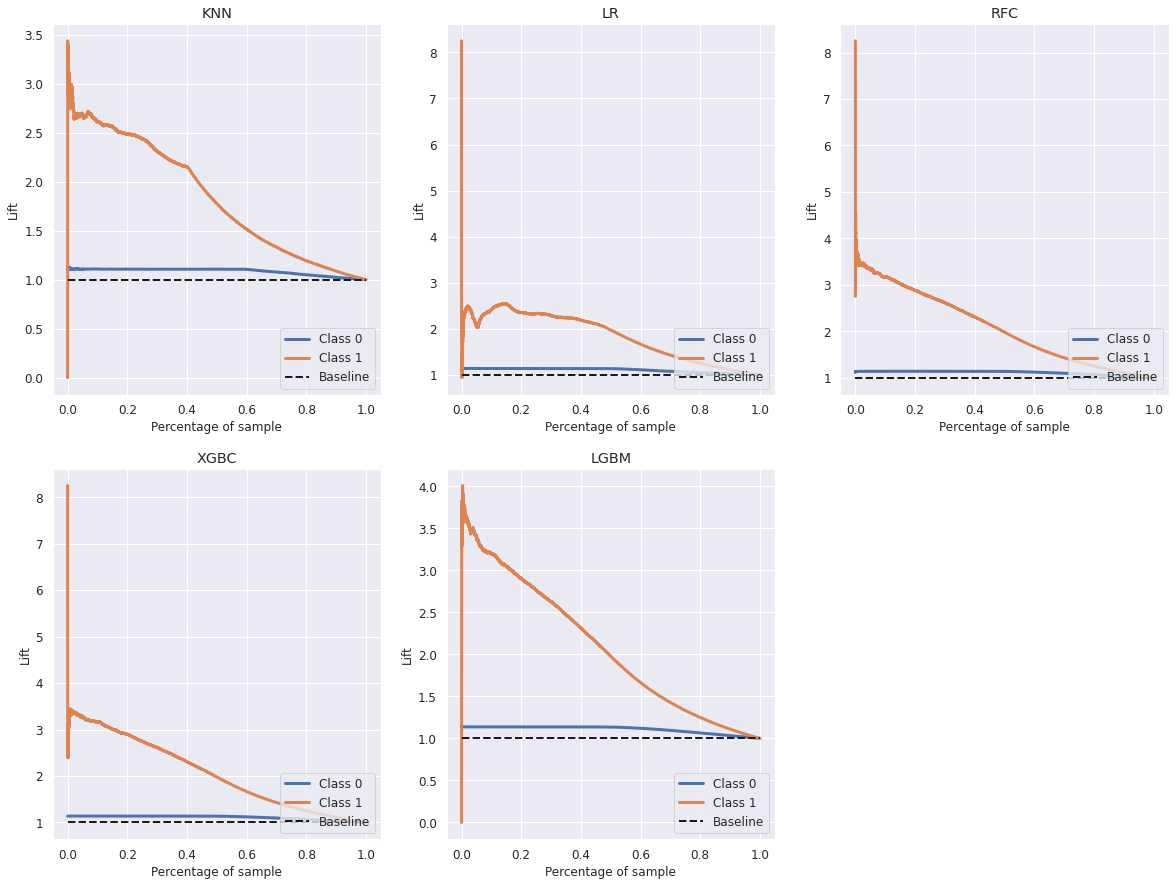

In [52]:
fig = plt.figure(figsize=(20,15))
specs = gridspec.GridSpec(ncols=3,nrows=2)

ax1 = fig.add_subplot(specs[0, 0]) 
ax2 = fig.add_subplot(specs[0, 1]) 
ax3 = fig.add_subplot(specs[0, 2]) 
ax4 = fig.add_subplot(specs[1, 0]) 
ax5 = fig.add_subplot(specs[1, 1]) 

skplt.metrics.plot_lift_curve(y_val,yhat_knn, ax=ax1 ,  title='KNN');
skplt.metrics.plot_lift_curve(y_val,yhat_lr , ax=ax2 , title='LR' );
skplt.metrics.plot_lift_curve(y_val,yhat_rf  , ax=ax3 , title='RFC' );
skplt.metrics.plot_lift_curve(y_val,yhat_xgb , ax=ax4 , title='XGBC' );
skplt.metrics.plot_lift_curve(y_val,yhat_lgbm , ax=ax5 , title='LGBM' );    

## 7.8 Compare Model's Performance

In [54]:
df7b = x_validation.copy()
df7b['response'] = y_validation.copy()

### 7.8.1 Single Performance

In [38]:
model_rank = pd.DataFrame(columns={'Model':[], "Precision_at_k": [], "Recall_at_k": []})
model_rank_1 = model_results (knn_model, "KNN Classifier", df7b, 20000 )
model_rank_2 = model_results (lr_model, "Logistic Regression Classifier", df7b, 20000 )
model_rank_3 = model_results (rf, "Random Forest Classifier", df7b, 20000 )
model_rank_4 = model_results (model_xgb, "XGBoost Classifier", df7b, 20000 )
model_rank_5 = model_results (lgbm, "LGBM Classifier", df7b, 20000 )

In [39]:
res_total = pd.concat([model_rank_1, model_rank_2, model_rank_3, model_rank_4, model_rank_5], axis=0)
res_total.sort_values('Recall_at_k', ascending = False).reset_index(drop=True)

,Model,Precision_at_k,Recall_at_k
0,LGBM Classifier,0.329434,0.708723
1,Random Forest Classifier,0.328684,0.707110
2,XGBoost Classifier,0.326834,0.703130
3,KNN Classifier,0.290685,0.625363
4,Logistic Regression Classifier,0.284936,0.612993


### 7.8.2 Real Performance - Cross Validation

In [40]:
# K-Nearest Neighbours
cv_knn = cross_validation(knn_model, x_train, y_train, 20000, df7b, 5) 

# Logistic Regression
cv_lr = cross_validation(lr_model, x_train, y_train, 20000, df7b, 5) 

# Random Forest
cv_rf = cross_validation(rf, x_train, y_train, 20000, df7b, 5) 

# XGBoost
cv_xgb = cross_validation(model_xgb, x_train, y_train, 20000, df7b, 5) 

#LGBM Classifier
cv_lgbm = cross_validation(lgbm, x_train, y_train, 20000, df7b, 5) 

Model Name: KNeighborsClassifier(n_neighbors=7)
Fold Number 1/5
Model Name: KNeighborsClassifier(n_neighbors=7)
Fold Number 2/5
Model Name: KNeighborsClassifier(n_neighbors=7)
Fold Number 3/5
Model Name: KNeighborsClassifier(n_neighbors=7)
Fold Number 4/5
Model Name: KNeighborsClassifier(n_neighbors=7)
Fold Number 5/5
Model Name: LogisticRegression(random_state=42)
Fold Number 1/5
Model Name: LogisticRegression(random_state=42)
Fold Number 2/5
Model Name: LogisticRegression(random_state=42)
Fold Number 3/5
Model Name: LogisticRegression(random_state=42)
Fold Number 4/5
Model Name: LogisticRegression(random_state=42)
Fold Number 5/5
Model Name: RandomForestClassifier(max_depth=10, random_state=42)
Fold Number 1/5
Model Name: RandomForestClassifier(max_depth=10, random_state=42)
Fold Number 2/5
Model Name: RandomForestClassifier(max_depth=10, random_state=42)
Fold Number 3/5
Model Name: RandomForestClassifier(max_depth=10, random_state=42)
Fold Number 4/5
Model Name: RandomForestClassifi

In [41]:
res_total_cv = pd.concat([cv_knn, cv_lr, cv_rf, cv_xgb, cv_lgbm], axis=0)
res_total_cv

,Model Name,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD
0,KNeighborsClassifier,0.2758,0.0014,0.7371,0.0037
0,LogisticRegression,0.2769,0.0017,0.7401,0.0044
0,RandomForestClassifier,0.3090,0.0020,0.8259,0.0053
0,GradientBoostingClassifier,0.3083,0.0021,0.8241,0.0057
0,LGBMClassifier,0.3099,0.0019,0.8283,0.0050


# 8.0 HYPERPARAMETER FINE TUNING

In [55]:
df8 = df7b.copy()

## 8.1 Random Search

In [43]:
MAX_EVAL = 10

lgbm_parameter = {'num_leaves': (5,15,45,60,90),
                  'max_depth': (5, 7, 10 ),
                  'min_split_gain': (0.001, 0.01 ,0.1),
                  'min_child_weight': (10,30,40,50),
                  'subsample':(0.5, 1),
                  'colsample_bytree':(0.1, 1)
                 }

In [50]:
hp_result=pd.DataFrame()

for i in range( MAX_EVAL):
    # choose values for parameters randomly
    hp = {k: rd.sample( v, 1)[0]for k, v in lgbm_parameter.items() }
    print( hp )
    
    # model
    lgbm = LGBMClassifier(num_leaves=hp['num_leaves'],
                                  max_depth=hp['max_depth'],
                                  min_split_gain=hp['min_split_gain'],
                                  min_child_weight=hp['min_child_weight'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'])
    
    # model training
    lgbm.fit( x_train, y_train )

    # model prediction - Power of generalization
    yhat_lgbm = lgbm.predict_proba( x_val )
         
    lgbm_result_hp = model_results (lgbm, "LGBM Classifier", df7b, 20000 )
  
    hp_result=pd.concat([hp_result,lgbm_result_hp])

hp_result

{'num_leaves': 60, 'max_depth': 7, 'min_split_gain': 0.01, 'min_child_weight': 50, 'subsample': 0.5, 'colsample_bytree': 0.1}
{'num_leaves': 90, 'max_depth': 7, 'min_split_gain': 0.001, 'min_child_weight': 30, 'subsample': 0.5, 'colsample_bytree': 1}
{'num_leaves': 90, 'max_depth': 7, 'min_split_gain': 0.001, 'min_child_weight': 10, 'subsample': 0.5, 'colsample_bytree': 0.1}
{'num_leaves': 15, 'max_depth': 5, 'min_split_gain': 0.001, 'min_child_weight': 50, 'subsample': 0.5, 'colsample_bytree': 0.1}
{'num_leaves': 90, 'max_depth': 10, 'min_split_gain': 0.01, 'min_child_weight': 40, 'subsample': 0.5, 'colsample_bytree': 1}
{'num_leaves': 90, 'max_depth': 7, 'min_split_gain': 0.1, 'min_child_weight': 40, 'subsample': 0.5, 'colsample_bytree': 1}
{'num_leaves': 45, 'max_depth': 5, 'min_split_gain': 0.01, 'min_child_weight': 40, 'subsample': 1, 'colsample_bytree': 1}
{'num_leaves': 5, 'max_depth': 5, 'min_split_gain': 0.1, 'min_child_weight': 50, 'subsample': 0.5, 'colsample_bytree': 0.1}
{

,Model,Precision_at_k,Recall_at_k
0,LGBM Classifier,0.329034,0.707863
0,LGBM Classifier,0.330283,0.710552
0,LGBM Classifier,0.329034,0.707863
0,LGBM Classifier,0.330233,0.710444
0,LGBM Classifier,0.330483,0.710982
0,LGBM Classifier,0.331083,0.712273
0,LGBM Classifier,0.330683,0.711412
0,LGBM Classifier,0.330183,0.710337
0,LGBM Classifier,0.330183,0.710337
0,LGBM Classifier,0.330433,0.710874


## 8.2 Final Model

In [56]:
# {'num_leaves': 90, 'max_depth': 7, 'min_split_gain': 0.1, 'min_child_weight': 40, 'subsample': 0.5, 'colsample_bytree': 1}

#model
model_lgbm_tuned=LGBMClassifier(objective = 'binary',
                                num_leaves=90,
                                max_depth=7,
                                min_split_gain=0.1,
                                min_child_weight=40,
                                subsample=0.5,
                                colsample_bytree=1).fit(x_train,y_train)

lgbm_tuned = model_results(model_lgbm_tuned, "LGBM Classifier", df8, 20000 )

# model prediction
yhat_lgbm_tuned = model_lgbm_tuned.predict_proba(x_val)

lgbm_tuned

,Model,Precision_at_k,Recall_at_k
0,LGBM Classifier,0.325984,0.711402


# 9.0 BUSINESS PERFORMANCE

 - Que porcentagem de clientes interessados em comprar seguro de automóveis a equipe de vendas poderá atingir com 20.000 ligações?

-  E se a capacidade da equipe de vendas aumentar para 40.000 chamadas, que porcentagem de clientes interessados em adquirir seguro de automóveis a equipe de vendas poderá entrar em contato?


- Quantas ligações a equipe de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir seguro de automóveis?


- Qual será a expectativa de receita com a nova base de clientes?

In [57]:
df9 = df8.copy()

In [58]:
df9 = df9.sort_values('score', ascending=False)

## 9.1 - 20.000 Calls

In [59]:
percent_of_dataset = 20000 / len(df9)
recall_at_20000 = recall_at_k(df9, k = 20000)
precision_at_20000=precision_at_k(df9,k=20000)

print('Percent of Data: ',percent_of_dataset)
print('Recall at 20000: ',recall_at_20000)
print('Precision at 20000: ',precision_at_20000)

Percent of Data:  0.2623914355435439
Recall at 20000:  0.7114020731042008
Precision at 20000:  0.32598370081495925


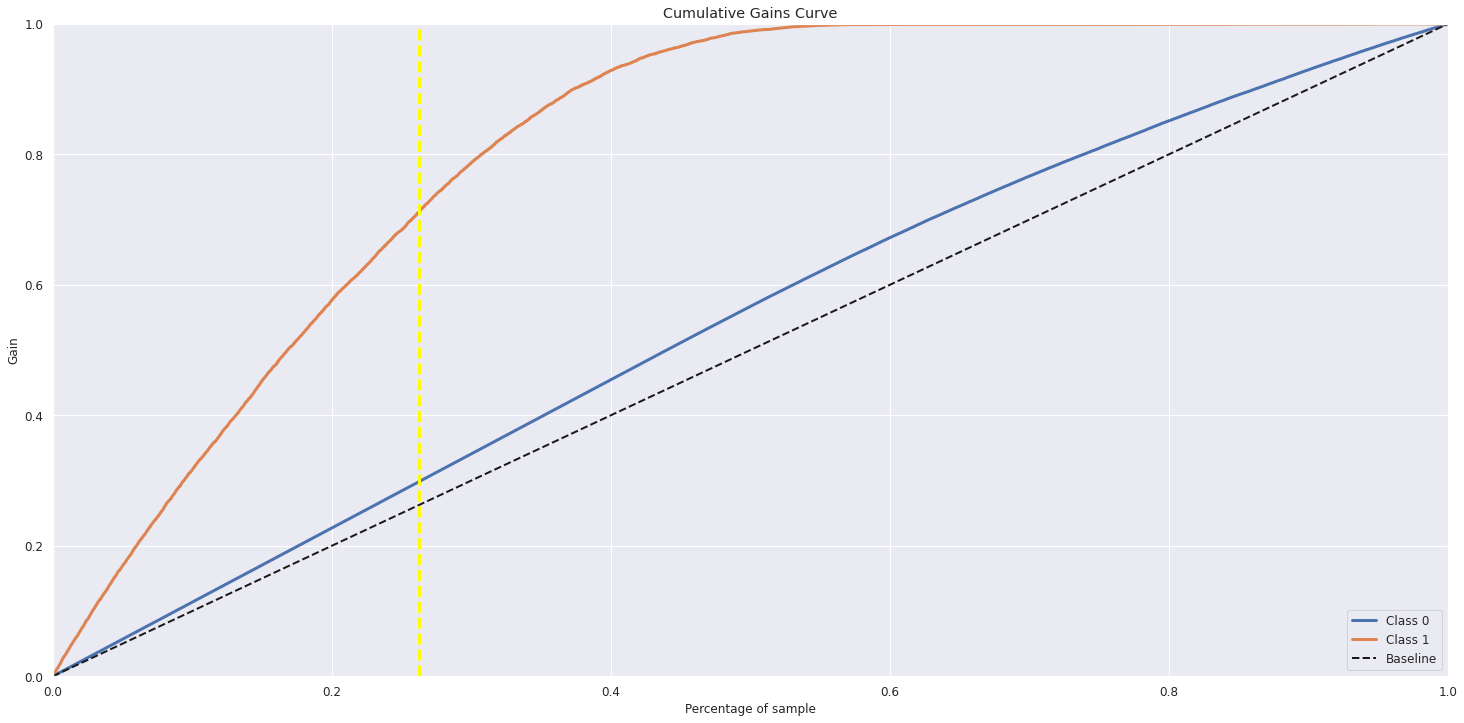

In [60]:
#skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm_tuned)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show();

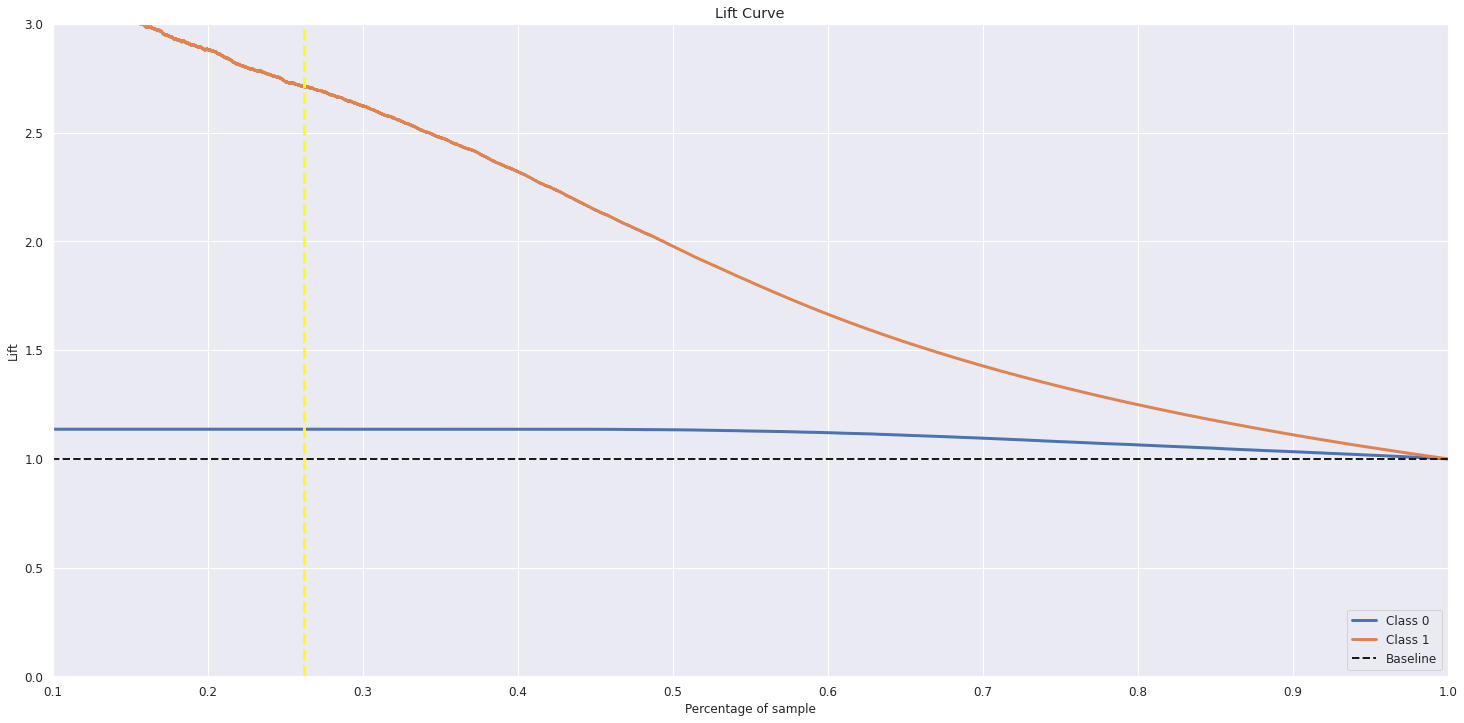

In [61]:
skplt.metrics.plot_lift_curve(y_val, yhat_lgbm_tuned)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3);
plt.xlim(0.1,1);
plt.ylim(0,3);

## 9.2 - 40.000 Calls

In [62]:
percent_of_dataset = 40000 / len(df9)
recall_at_40000 = recall_at_k(df9, k = 40000)
precision_at_40000=precision_at_k(df9,k=40000)

print('Percent of Data: ',percent_of_dataset)
print('Recall at 40000: ',recall_at_40000)
print('Precision at 40000: ',precision_at_40000)

Percent of Data:  0.5247828710870878
Recall at 40000:  0.9943262411347518
Precision at 40000:  0.22781930451738708


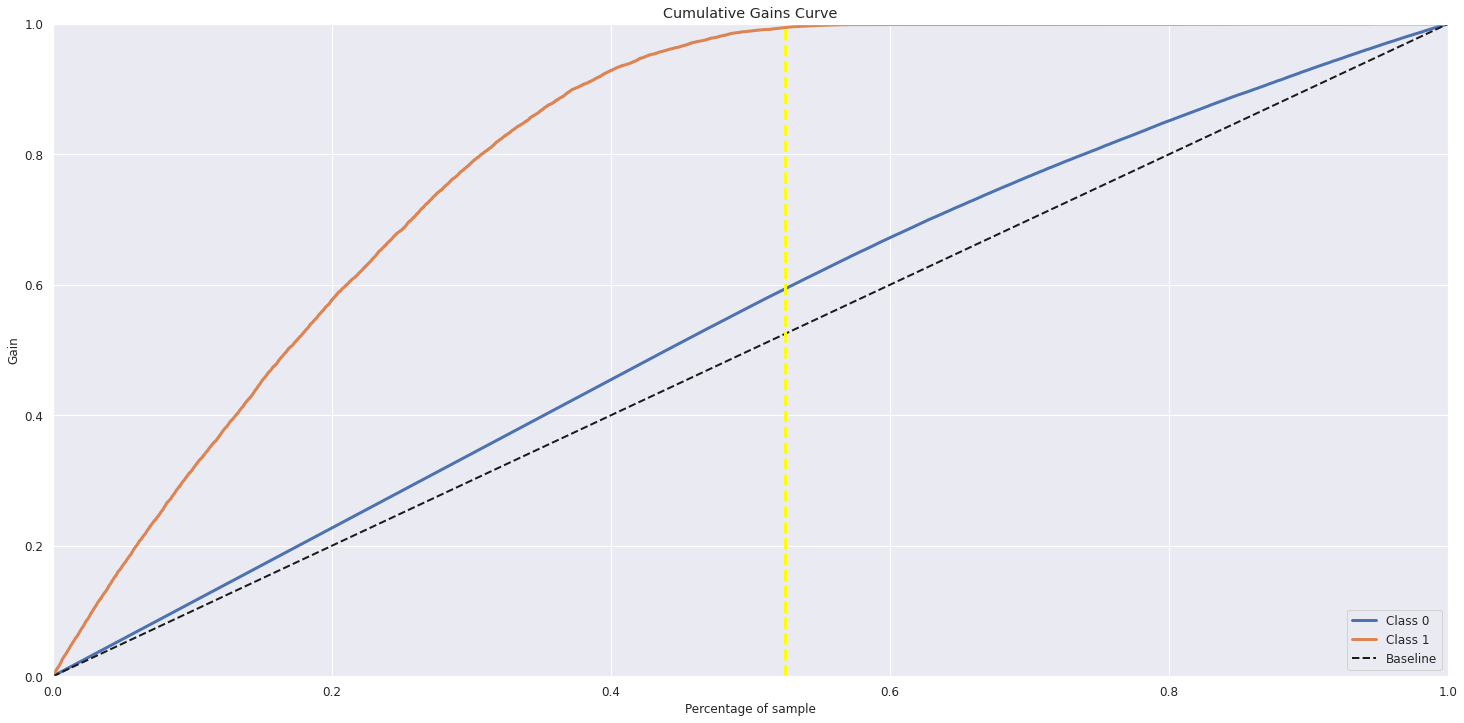

In [63]:
#skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm_tuned)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show();

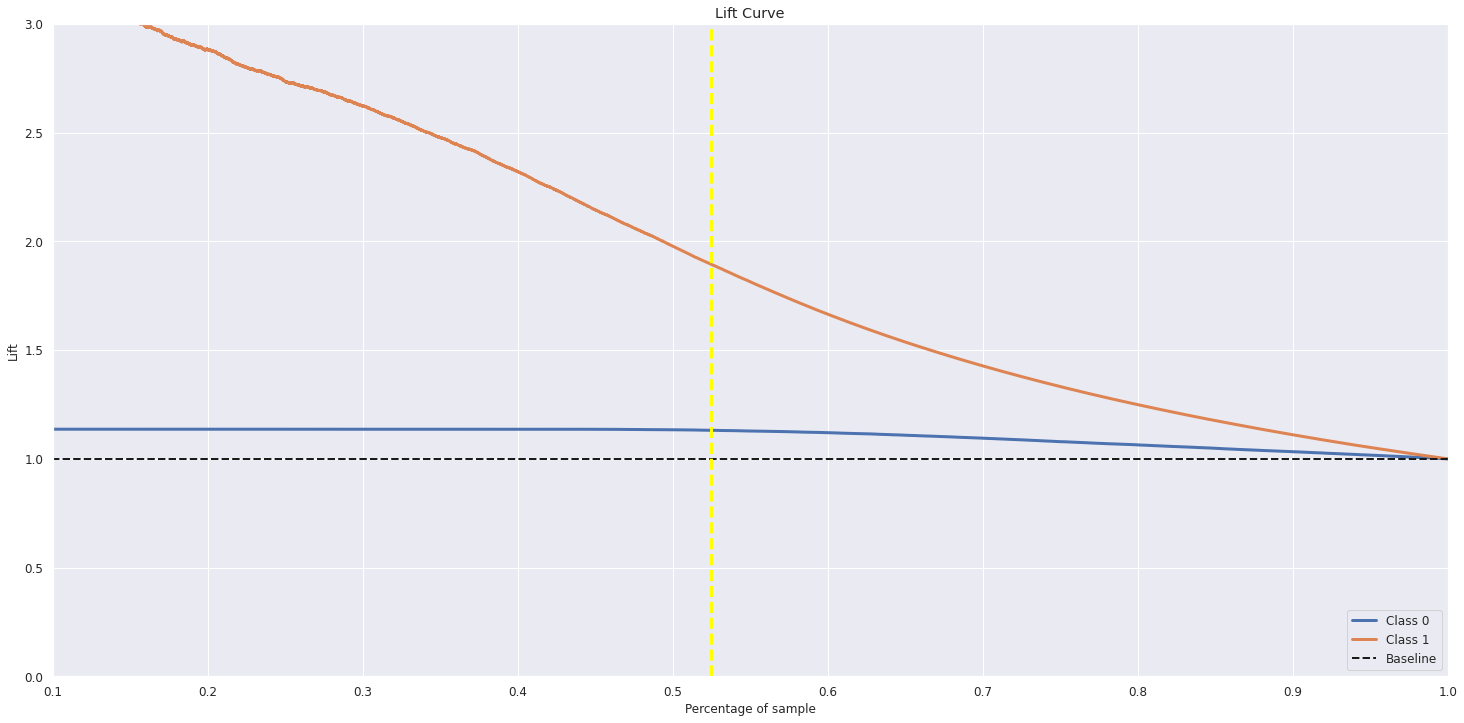

In [64]:
skplt.metrics.plot_lift_curve(y_val, yhat_lgbm_tuned)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3);
plt.xlim(0.1,1);
plt.ylim(0,3);

## 9.3 Question - How many calls does the sales team need to make to reach 80% of customers interested in purchasing auto insurance?

In [65]:
recall_at_x = 0
i = 20000

while recall_at_x < 0.80:
    percent_of_dataset = i / len(df9)
    recall_at_x = recall_at_k(df9, k = i)
    precision_at_x=precision_at_k(df9,k=i) 
    i=i+1
   
print('To contact 80% of customers interested in purchasing car insurance would require {} calls'.format(i))        
print('Percent of Data: ',percent_of_dataset)
print('Recall at x: ',recall_at_x)
print('Precision at x: ',precision_at_x)

To contact 80% of customers interested in purchasing car insurance would require 23416 calls
Percent of Data:  0.30719477316260396
Recall at x:  0.8
Precision at x:  0.3131192347113085


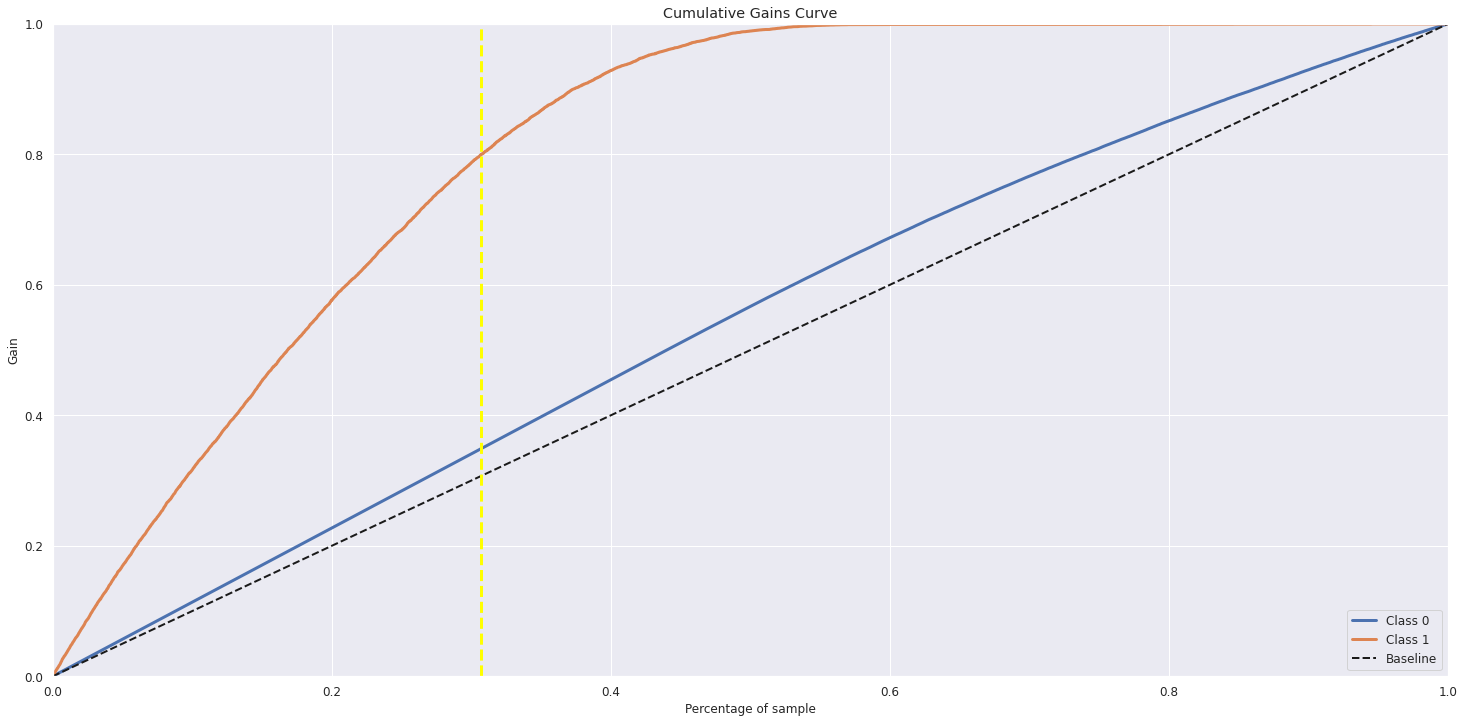

In [68]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm_tuned)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 

## 9.4 Business Performance on 127.000 New Customers

Whereas the average auto insurance value at US$1,674 (according to 2022 data extracted from Quadrant Information Services)

### 9.4.1 Expected revenue making 20,000 calls

In [69]:
random = (26.23/100) * 127000
model  = (71.14/100) * 127000

x = random * (1674*12) 
y = model *  (1674*12) 
dif=y-x

print('Expected annual revenue with random choice: US$ {} '.format(x))
print('Expected annual with model: US$ {} '.format(y))
print('Difference in US$: {} '.format(dif)  )

Expected annual revenue with random choice: US$ 669173464.8 
Expected annual with model: US$ 1814906606.4 
Difference in US$: 1145733141.6000001 


### 9.4.2 Expected revenue making 40,000 calls

In [70]:
random = (52.47/100) * 127000
model  = (99.36/100) * 127000

x = random * (2000*12)
y = model *  (2000*12)
dif=y-x

print('Expected annual revenue with random choice: US$ {} '.format(x))
print('Expected annual with model: US$ {} '.format(y))
print('Difference in US$: {} '.format(dif)  )

Expected annual revenue with random choice: US$ 1599285599.9999998 
Expected annual with model: US$ 3028492800.0000005 
Difference in US$: 1429207200.0000007 


# 10.0 DEPLOY TO PRODUCTION

In [71]:
# Save Trained Model
pickle.dump(model_lgbm_tuned, open('/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/model/model_health_insurance.pkl', 'wb'))

## 10.1 Health Insurance Class

In [122]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsurance(object):
   
    def __init__( self ):
        self.home_path = '/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/'
        self.annual_premium_scaler =            pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb' ) )
        self.age_scaler =                       pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb' ) ) 
        self.vintage_scaler =                   pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb' ) ) 
        self.target_encode_gender_scaler =      pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl', 'rb' ) )
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + 'src/features/target_encode_region_code_scaler.pkl', 'rb' ) )
        self.fe_policy_sales_channel_scaler =   pickle.load( open( self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl', 'rb' ) )
        
    def data_cleaning( self, df1 ):
        
        df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)
        df1['region_code'] = df1['region_code'].astype(int)

        return df1 
    
    def feature_engineering( self, df2 ):
        
        # Change feature vehicle age 
        df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

        # Change feature vehicle damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)
        
        return df2
    
    def data_preparation( self, df3 ):
        
        # anual premium - StandardScaler
        df3['annual_premium'] = self.annual_premium_scaler.transform( df3[['annual_premium']].values )

        # Age - MinMaxScaler
        df3['age'] = self.age_scaler.transform( df3[['age']].values )

        # Vintage - MinMaxScaler
        df3['vintage'] = self.vintage_scaler.transform( df3[['vintage']].values )

        # gender - Target Encoding
        df3.loc[:, 'gender'] = df3['gender'].map( self.target_encode_gender_scaler )

        # region_code - Target Encoding
        df3.loc[:, 'region_code'] = df3['region_code'].map( self.target_encode_region_code_scaler )

        # vehicle_age - One Hot Encoding
        df3 = pd.get_dummies( df3, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Frequency Encoding
        df3.loc[:, 'policy_sales_channel'] = df3['policy_sales_channel'].map( self.fe_policy_sales_channel_scaler )
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']
        
        return df3[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['score'] = pred[:,1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )
        

## 10.2 API Handler

In [123]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

# loading model
path = '/home/felipe_rastelli/repositorios/pa004_health_insurance_cross_sell/health_insurance_cross-sell/'
model = pickle.load( open( path + 'src/model/model_health_insurance.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/predict', methods=['POST'] )
def healthinsurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )

ModuleNotFoundError: No module named 'healthinsurance'

## 10.3 API Tester

In [209]:
# loading test dataset
df_test = x_validation

# df_test = df_test.sample(30)

In [210]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [211]:
# API Call
# url = 'http://0.0.0.0:5000/predict'
url = 'https://health-insurance-fr.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [212]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head(30)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,score
71774,227567,0.138733,0.261538,0.193548,157,1,below_1_year,0,0,-0.040983,0.311419,0.001603
29435,66923,0.138733,0.200000,0.187104,124,1,below_1_year,0,0,0.002685,0.217993,0.001555
22388,39688,0.138733,0.276923,0.130769,124,1,below_1_year,0,0,-0.119491,0.325260,0.001547
43418,124606,0.138733,0.276923,0.153074,124,1,below_1_year,0,0,-0.112697,0.328720,0.001541
7776,5559,0.104828,0.276923,0.187104,26,1,below_1_year,0,0,-0.144286,0.318339,0.001541
31588,154354,0.104828,0.276923,0.187104,26,1,below_1_year,0,0,-0.114671,0.314879,0.001541
21260,55659,0.138733,0.292308,0.134821,26,1,below_1_year,0,0,-0.114149,0.321799,0.001538
6333,313358,0.104828,0.215385,0.187104,154,1,below_1_year,0,0,0.005182,0.688581,0.001529
19013,185555,0.104828,0.200000,0.153074,26,1,below_1_year,0,0,-0.019381,0.138408,0.001522
39763,69602,0.138733,0.261538,0.112234,124,1,below_1_year,0,0,2.315373,0.913495,0.001519


## 10.4 Google Sheets App - Script

In [ ]:
// PA004 Health Insurance Cross-sell
function onOpen() {
  var ui = SpreadsheetApp.getUi();
  ui.createMenu( 'Health Insurance Prediction' )
    .addItem(  'Get Prediction','PredictAll')
    .addToUi();
}

// Production Server
host_production = 'health-insurance-fr.herokuapp.com'

// ----------------------------
// ----- Helper Function ------
// ----------------------------

// API Call
function ApiCall( data, endpoint ){
  var url = 'https://' + host_production + endpoint;
  var payload = JSON.stringify( data );

  var options = {'method': 'POST', 'contentType': 'application/json', 'payload': payload};

  Logger.log( url )
  Logger.log( options )

  var response = UrlFetchApp.fetch( url, options );

  // get response
  var rc = response.getResponseCode();
  var responseText = response.getContentText();

  if ( rc !== 200 ){
    Logger.log( 'Response (%s) %s', rc, responseText );
  }
  else{
    prediction = JSON.parse( responseText );
  }
  return prediction
};

// Health Insurance Propensity Score Prediction

function PredictAll(){
  //google sheets parameters
  var ss = SpreadsheetApp.getActiveSheet();
  var titleColumns = ss.getRange( 'A1:K1' ).getValues()[0];
  var lastRow = ss.getLastRow();
  
  var data = ss.getRange( 'A2' + ':' + 'K' + lastRow ).getValues();

  // run over all rows
  for ( row in data ){
    var json = new Object();

    // run over all columns
    for( var j=0; j < titleColumns.length; j++ ){
      json[titleColumns[j]] = data[row][j];
    };

    // Json file to send
    var json_send = new Object();
    json_send['id'] = json['id']
    json_send['gender'] = json['gender']
    json_send['age'] =  json['age']
    json_send['driving_license'] = json['driving_license']
    json_send['region_code'] = json['region_code']
    json_send['previously_insured'] = json['previously_insured']
    json_send['vehicle_age'] = json['vehicle_age']
    json_send['vehicle_damage'] = json['vehicle_damage']
    json_send['annual_premium'] = json['annual_premium']
    json_send['policy_sales_channel'] = json['policy_sales_channel']
    json_send['vintage'] = json['vintage']
       
    Logger.log( json_send);
   
    // Propensity score
    pred = ApiCall( json_send, '/predict' );

    // Send back to google sheets
    ss.getRange( Number( row ) + 2 , 12 ).setValue( pred[0]['score'] )
    Logger.log( pred[0]['score'] )

  };
};